In [1]:
import sys
import numpy as np
import spectral as sp
import matplotlib as mpl
import matplotlib.pyplot as plt

sys.path.append('../')
from preprocessing import *
from extinctions import *
from plotting_parameters import *
from skimage import filters

/home/martin_ivan/anaconda3/envs/thesis/lib/python3.10/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


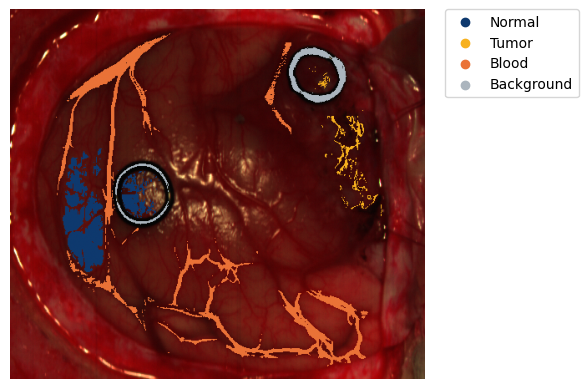

In [2]:
bands_range = [520,900]

data_folder = "../../datasets/helicoid/012-01"
# data_folder = "../../datasets/helicoid/008-01"

class_labels = ["Not labled", "Normal", "Tumor", "Blood", "Background"]
class_colors = ["white", tum_blue_dark_2, tum_orange, tum_red, tum_grey_5]

# Load the sp data
img = sp.open_image(data_folder + "/raw.hdr")
white_ref = sp.open_image(data_folder + "/whiteReference.hdr")
dark_ref = sp.open_image(data_folder + "/darkReference.hdr")
gt_map = sp.open_image(data_folder + "/gtMap.hdr")

plot_img(img, gt_map, class_labels, class_colors, figsize=(5,5), legend=True)


img_interp, band_centers = bands_lin_interpolation(img, img.bands.centers, bands_range)
white_ref_interp, _ = bands_lin_interpolation(white_ref, img.bands.centers, bands_range)
dark_ref_interp, _ = bands_lin_interpolation(dark_ref, img.bands.centers, bands_range)
img_calib = calibrate_img(img_interp, white_ref_interp, dark_ref_interp)
img_calib_norm = img_calib / np.linalg.norm(img_calib, axis=(0,1), ord=1, keepdims=True)
img_smooth = smooth_spectral(img_calib_norm, 5)
absorbance = -np.log(img_smooth - np.min(img_smooth.flatten()) + 1e-8)

In [3]:
bands_range = [520,900]
band_centers = np.arange(bands_range[0], bands_range[1]+1)
endmember_labels = ["oxCytc", "redCytc", "oxCytb", "redCytb", "oxCCO", "redCCO", "HHb", "HbO$_2$", "water", "lipids", "a'"]

extinction_dict = get_extinctions(bands_range)
cyt_c_ox = extinction_dict["cyt_c_ox"]
cyt_c_red = extinction_dict["cyt_c_red"]
cyt_b_ox = extinction_dict["cyt_b_ox"]
cyt_b_red = extinction_dict["cyt_b_red"]
cyt_oxi_ox = extinction_dict["cyt_oxi_ox"]
cyt_oxi_red = extinction_dict["cyt_oxi_red"]
hb = extinction_dict["hb"]
hbo2 = extinction_dict["hbo2"]
water = extinction_dict["water"]
fat = extinction_dict["fat"]
scatter_simple = (band_centers/500)**(-1.2)

spectra_folder = "../mc_sim/spectra_mc/"

hb_mc = np.loadtxt(spectra_folder + "m_hhb_50.txt")
hbo2_mc = np.loadtxt(spectra_folder + "m_hbo2_50.txt")

M_scatter_new = np.vstack((cyt_c_ox, cyt_c_red, cyt_b_ox, cyt_b_red, cyt_oxi_ox, cyt_oxi_red, hb_mc, hbo2_mc, water, fat, scatter_simple)).T
M_scatter_new_smooth = smooth_spectral(M_scatter_new.T,5).T

endmembers_remove = np.delete(M_scatter_new_smooth, 6, axis=1).T
data_hb_mc = osp(absorbance, endmembers_remove, hb_mc)

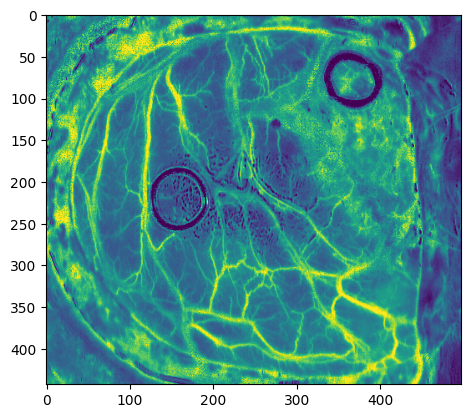

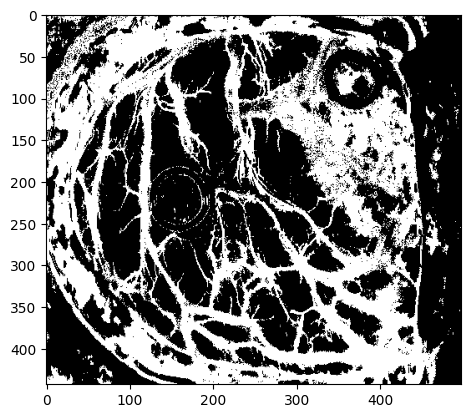

In [33]:
plt.imshow(clip_data(data_hb_mc))

data_hb_mc_clip = clip_data(data_hb_mc)
data_hb_mc_clip_norm = (data_hb_mc_clip - np.min(data_hb_mc_clip.flatten())) / (np.max(data_hb_mc_clip.flatten()) - np.min(data_hb_mc_clip.flatten()))
data_hb_mc_clip_norm[data_hb_mc_clip_norm<0.5] = 0
data_hb_mc_clip_norm[data_hb_mc_clip_norm>0.5] = 1
plt.figure()
plt.imshow(data_hb_mc_clip_norm, cmap="gray")

(443, 497)
(443, 497, 3)


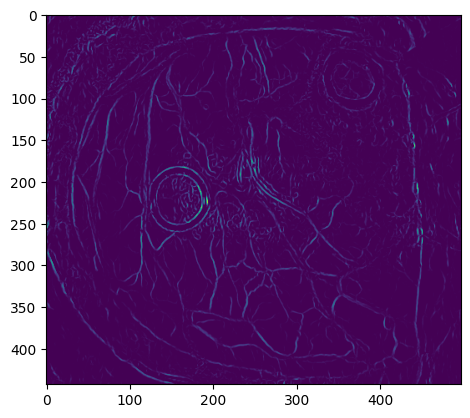

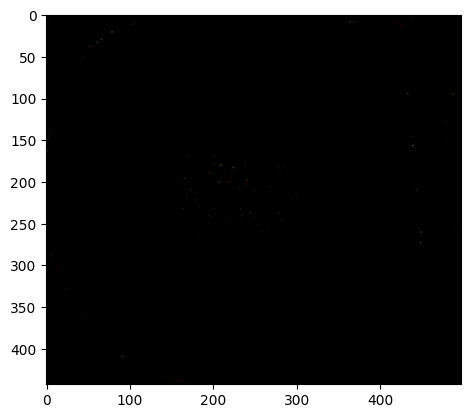

In [30]:
img_filtered = filters.frangi(clip_data(data_hb_mc), sigmas=(1,2,3), black_ridges=False)
print(img_filtered.shape)
plt.imshow(img_filtered)

img_filtered = filters.frangi(get_rgb(img), sigmas=(1,2,3), black_ridges=False)
print(img_filtered.shape)
plt.figure()
plt.imshow(img_filtered)

(443, 497)


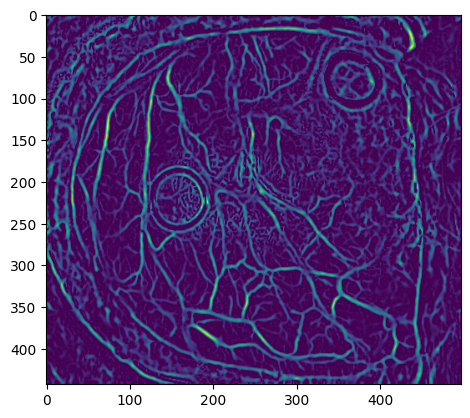

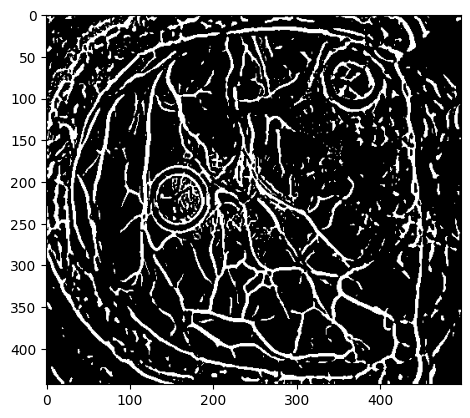

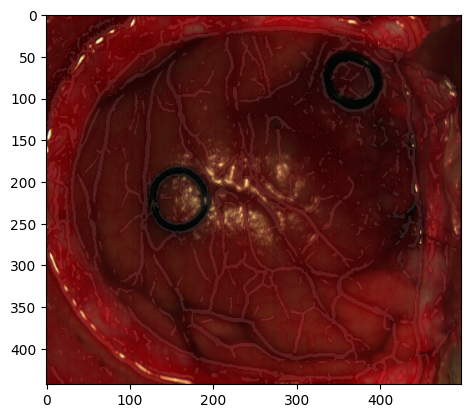

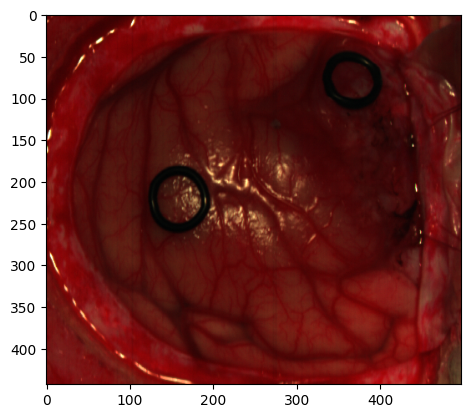

In [35]:
img_filtered = filters.meijering(clip_data(data_hb_mc), black_ridges=False, sigmas=(1,2))
print(img_filtered.shape)
plt.imshow(img_filtered)

img_filtered[img_filtered<0.2] = 0
img_filtered[img_filtered>0.2] = 1
plt.figure()
plt.imshow(img_filtered, cmap="gray")

# overlay on the rgb image
img_rgb = get_rgb(img)
plt.figure()
plt.imshow(img_rgb)
plt.imshow(img_filtered, alpha=0.1, cmap="gray")

plt.figure()
plt.imshow(get_rgb(img))

(443, 497)


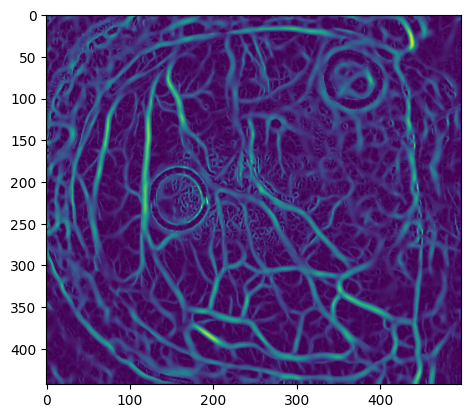

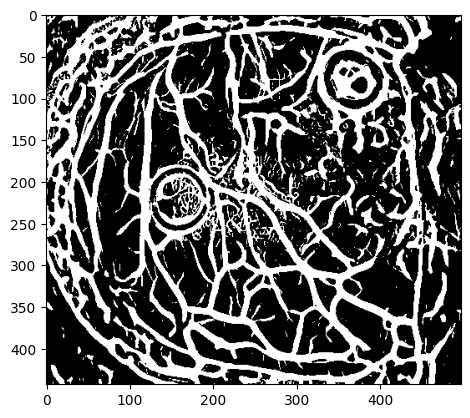

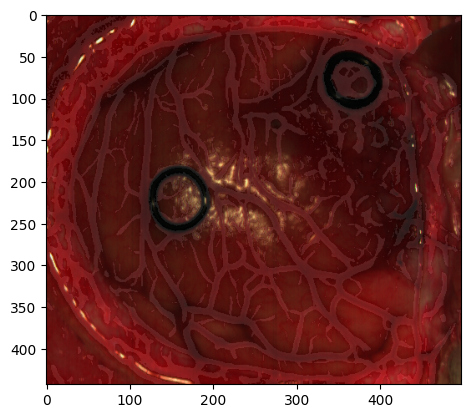

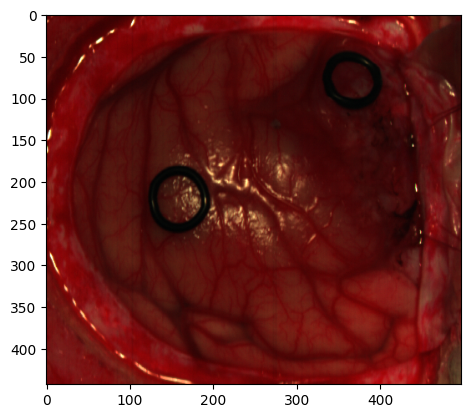

In [45]:
img_filtered = filters.sato(clip_data(data_hb_mc), black_ridges=False, sigmas=(1,2, 3, 4))
print(img_filtered.shape)
plt.imshow(img_filtered)

img_filtered[img_filtered<0.03] = 0
img_filtered[img_filtered>0.03] = 1
plt.figure()
plt.imshow(img_filtered, cmap="gray")

# overlay on the rgb image
img_rgb = get_rgb(img)
plt.figure()
plt.imshow(img_rgb)
plt.imshow(img_filtered, alpha=0.1, cmap="gray")

plt.figure()
plt.imshow(get_rgb(img))